<a href="https://colab.research.google.com/github/pratikiiitb2013/ERA/blob/main/S7/ERA1S7Code4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
### Normalize needs tensor(not np array)
# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 413927552.66it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111748795.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 108827698.26it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1747594.60it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


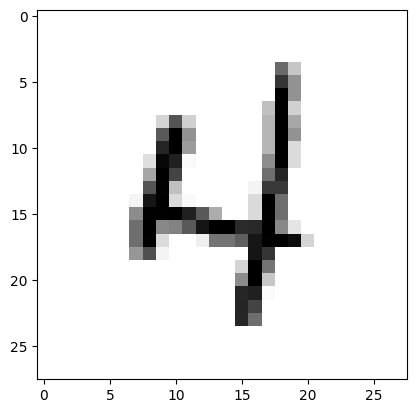

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

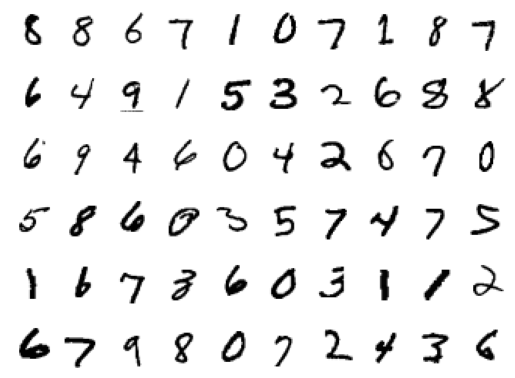

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

    # CONVOLUTION BLOCK 1
    self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
    ) # output_size = 24

    # TRANSITION BLOCK 1
    self.mp1 = nn.MaxPool2d(2, 2) # output_size = 12
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU()
    ) # output_size = 12

    # CONVOLUTION BLOCK 2
    self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
    ) # output_size = 10
    self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 8

    # TRANSITION BLOCK 2
    # self.mp2 = nn.MaxPool2d(2, 2) # output_size = 7
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        nn.BatchNorm2d(10),
        nn.ReLU()
    ) # output_size = 8

    # OUTPUT BLOCK
    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.BatchNorm2d(10),
        nn.ReLU()
    ) # output_size = 6

    self.convblock9 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(6, 6), padding=0, bias=False),
    )# output_size = 1

  def forward(self, x):
    x = self.convblock2(self.convblock1(x))
    x = self.mp1(x)
    x = self.convblock3(x)
    x = self.convblock5(self.convblock4(x))
    # x = self.mp2(x)
    x = self.convblock6(x)
    # x = self.convblock9(self.convblock8(self.convblock7(x)))
    x = self.convblock9(self.convblock7(x))

    x = x.view(-1, 10) #1x1x10> 10
    return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# model = Net().to(device)
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]              80
       BatchNorm2d-9            [-1, 8, 12, 12]              16
             ReLU-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             720
      BatchNorm2d-12           [-1, 10, 10, 10]              20

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # print(correct)
    # print(processed)
    # print(len(train_losses))

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
# model =  Net().to(device)
model =  Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.11002754420042038 Batch_id=468 Accuracy=93.90: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]



Test set: Average loss: 0.0683, Accuracy: 9795/10000 (97.95%)

EPOCH: 1


Loss=0.02105402946472168 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0443, Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.05876101925969124 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]



Test set: Average loss: 0.0480, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.03088134527206421 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]



Test set: Average loss: 0.0392, Accuracy: 9870/10000 (98.70%)

EPOCH: 4


Loss=0.16483278572559357 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]



Test set: Average loss: 0.0421, Accuracy: 9858/10000 (98.58%)

EPOCH: 5


Loss=0.003279181197285652 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]



Test set: Average loss: 0.0357, Accuracy: 9877/10000 (98.77%)

EPOCH: 6


Loss=0.07237889617681503 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]



Test set: Average loss: 0.0346, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.005078171845525503 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]



Test set: Average loss: 0.0318, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.011676530353724957 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0438, Accuracy: 9858/10000 (98.58%)

EPOCH: 9


Loss=0.007663855794817209 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0297, Accuracy: 9909/10000 (99.09%)

EPOCH: 10


Loss=0.002190134720876813 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]



Test set: Average loss: 0.0301, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.014148364774882793 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]



Test set: Average loss: 0.0325, Accuracy: 9893/10000 (98.93%)

EPOCH: 12


Loss=0.009095938876271248 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0326, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.003783436492085457 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.0341, Accuracy: 9899/10000 (98.99%)

EPOCH: 14


Loss=0.009648098610341549 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]



Test set: Average loss: 0.0314, Accuracy: 9899/10000 (98.99%)



In [14]:
# train_losses

In [15]:
t = [t_items.item() for t_items in train_losses]
len(t)

7035

Text(0.5, 1.0, 'Test Accuracy')

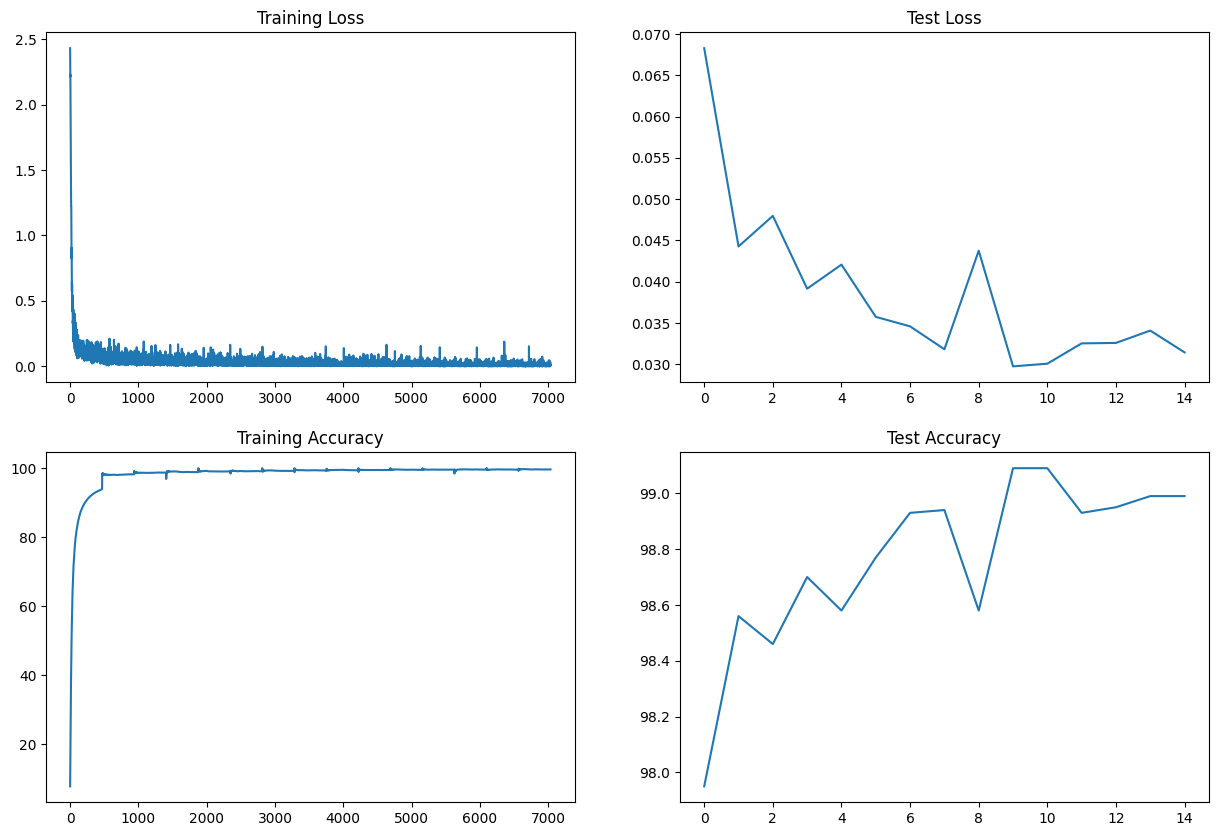

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
# Step 4 -

# 	Target:    Add Batch-norm to increase model efficiency.

# 	Results:   #Params - 8.4k, Train accuracy - 99.64%, Test accuracy - 99.09%

# 	Analysis:   now little overfitting again came back which we will be fixing in next steps.
# 				#parameters increased by ~200 because now batch norm paramaeters are added.